# Compare OSMnx and SharedStreets OSM Extractions

In [1]:
import geopandas as gpd
import json
import networkx as nx
import numpy as np
import pandas as pd
import osmnx as ox
import pyarrow.feather as arrow

### Step 1: Boundary to GeoJSON
[Source](https://gis-pdx.opendata.arcgis.com/datasets/portland-administrative-sextants)

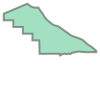

In [2]:
nw_pdx = gpd.read_file("https://opendata.arcgis.com/datasets/608f29b28c3f4e728f9e8dc8b2dc3f66_233.geojson")
nw_pdx = (
    nw_pdx[nw_pdx['Sextant'] == 'Northwest']
    .to_crs(epsg = 4326)
    .geometry
    .unary_union
)
nw_pdx

In [3]:
nw_pdx_gdf = gpd.GeoSeries([nw_pdx]).__geo_interface__

In [4]:
with open("nw_pdx.geojson", "w") as f:
    json.dump(nw_pdx_gdf, f)

### Step 2: OSMnx Extraction

In [5]:
graph = ox.graph_from_polygon(
    nw_pdx, 
    network_type = 'all', 
    simplify = True)

In [6]:
link_gdf = ox.graph_to_gdfs(graph, nodes = False, edges = True)

In [7]:
link_gdf['osmid'] = (
 pd.DataFrame(link_gdf.osmid.tolist())
   .fillna('')
   .astype(str)
   .agg(','.join, 1)
   .str.strip(',')
)

link_gdf.head()

,osmid,name,highway,maxspeed,oneway,length,geometry,service,lanes,access,est_width,ref,tunnel,bridge,width,junction,area,u,v,key
0,5525085,Northwest 56th Avenue,residential,20 mph,False,76.893,"LINESTRING (-122.74535 45.56225, -122.74461 45...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40566785,40526352,0
1,"[5538434, 5537102]","[Northwest 57th Avenue, Northwest Willbridge A...",residential,20 mph,False,111.905,"LINESTRING (-122.74535 45.56225, -122.74620 45...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40566785,1343928347,0
2,"[5539554, 5537102]","[Northwest 55th Avenue, Northwest Willbridge A...",residential,20 mph,False,176.349,"LINESTRING (-122.74535 45.56225, -122.74454 45...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40566785,3595584074,0
3,399013367,NaN,service,NaN,False,37.307,"LINESTRING (-122.68267 45.52652, -122.68266 45...",parking_aisle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4017520648,4017520622,0
4,373556233,Northwest Glisan Street,secondary,20 mph,True,47.023,"LINESTRING (-122.68267 45.52652, -122.68318 45...",NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4017520648,40684643,0


In [8]:
osmnx_gdf = link_gdf[['osmid', 'u', 'v', 'geometry']]
osmnx_gdf.to_file('osmnx_link.geojson', driver='GeoJSON')

### Step 3: SharedStreets Extraction (use node.js via Docker)

In [9]:
! docker build -t shst .
! docker run -it --rm -v ~/Documents/GitHub/osm-extract-validator:/usr/node/ shst:latest shst extract usr/node/nw_pdx.geojson --out=usr/node/shst.geojson --metadata --tile-hierarchy=8 --tiles

Sending build context to Docker daemon  286.8MB
Step 1/5 : FROM node:10
 ---> d7f435065057
Step 2/5 : ENV NPM_CONFIG_PREFIX=/home/node/.npm-global
 ---> Using cache
 ---> 3d4c7655e0dd
Step 3/5 : ENV PATH=$PATH:/home/node/.npm-global/bin
 ---> Using cache
 ---> d10cfa8e94ae
Step 4/5 : USER node
 ---> Using cache
 ---> 7c2a4ea3bae2
Step 5/5 : RUN npm install -g sharedstreets@0.12.4
 ---> Using cache
 ---> b3f94b79e804
Successfully built b3f94b79e804
Successfully tagged shst:latest
  🌏  Loading polygon...
  🗄️  Loading SharedStreets tiles...
  🔍  Searching data...
     writing to cache: /home/node/.shst/cache/tiles/osm/planet-181224/12-650-1463.geometry.8.pbf
     writing to cache: /home/node/.shst/cache/tiles/osm/planet-181224/12-650-1464.geometry.8.pbf
     writing to cache: /home/node/.shst/cache/tiles/osm/planet-181224/12-650-1465.geometry.8.pbf
     writing to cache: /home/node/.shst/cache/tiles/osm/planet-181224/12-651-1463.geometry.8.pbf
     writing to cache: /home/node/.shst/cach

In [10]:
shst_gdf = gpd.read_file('shst.out.geojson')

In [11]:
shst_gdf.head()

,id,fromIntersectionId,toIntersectionId,forwardReferenceId,backReferenceId,roadClass,metadata,geometry
0,46b824ecd0e12698f5b6fac3647b8239,b89a2b4a8f489a23b9b33e6428d928d3,510f6d4fe5ae8465789fcfab880264ed,77363b316a4a8270842db5e43bd98fc5,8486f1a1355fdd0ac8b9893f6d9a59e0,Other,"{'gisMetadata': [], 'geometryId': '46b824ecd0e...","LINESTRING (-122.68002 45.52143, -122.68014 45..."
1,9ba554d9e3b5213226bb4a21e7f175c4,b89a2b4a8f489a23b9b33e6428d928d3,a9b245c2a7d4067781972edf050a3255,c89e37636df1efd976085517818cbcd6,a49c1431a64caec88b99530862f8e400,Other,"{'gisMetadata': [], 'geometryId': '9ba554d9e3b...","LINESTRING (-122.68002 45.52143, -122.67998 45..."
2,9c87810a90400a14ad0a82f4beffb7ea,7f834a3241aada1590e41edcd3f9d3a0,abf792f4b2cc3b290d579c53c1a95e28,3b7ac8f9b33f79c5a57f534178d91340,78fcf95c29aac47e27662ed1959fccd7,Other,"{'gisMetadata': [], 'geometryId': '9c87810a904...","LINESTRING (-122.68005 45.52164, -122.68000 45..."
3,ec448b21e15a6f30d6565b96dc445850,510f6d4fe5ae8465789fcfab880264ed,7f834a3241aada1590e41edcd3f9d3a0,66fb67df2d80b7f6b971e1674302795e,e1660d691ce3a62ac447019e21b60f89,Other,"{'gisMetadata': [], 'geometryId': 'ec448b21e15...","LINESTRING (-122.68014 45.52147, -122.68005 45..."
4,ddebca518bb2006fe5e50c3b3e9b97f7,93c816f5e53f5a0e73d1f2418a1401da,5cd71ffcda7f0eac80d86cc8050a2b9f,4f86f9298a041b80742c67ba29a3cd70,dd36d8d2a054b832c1ef8641b2e69971,Other,"{'gisMetadata': [], 'geometryId': 'ddebca518bb...","LINESTRING (-122.68103 45.52177, -122.68113 45..."


In [12]:
no_dup_gdf = shst_gdf.drop_duplicates(
    subset = ['id', 'fromIntersectionId', 'toIntersectionId', 'forwardReferenceId', 'backReferenceId'])

In [13]:
def func(x, shst_link_df_list):
    df = pd.DataFrame(x.get('metadata').get('osmMetadata').get('waySections'))
    df['geometryId'] = x.get('metadata').get('geometryId')
    shst_link_df_list.append(df)
    
shst_link_df_list = []

no_dup_gdf.apply(
    lambda x: func(x, shst_link_df_list),
    axis = 1,
)

osm_link_df = pd.concat(shst_link_df_list)

osm_link_df.head()

,nodeIds,wayId,roadClass,oneWay,roundabout,link,name,geometryId
0,"[3775764800, 3775764803]",374186538,Other,False,False,False,,46b824ecd0e12698f5b6fac3647b8239
0,"[3775764800, 3775764802]",374186535,Other,False,False,False,,9ba554d9e3b5213226bb4a21e7f175c4
0,"[3775764822, 3775764809]",374186531,Other,False,False,False,,9c87810a90400a14ad0a82f4beffb7ea
1,"[3775764809, 3775764806]",374186546,Other,False,False,False,,9c87810a90400a14ad0a82f4beffb7ea
0,"[3775764803, 3775764822]",374186544,Other,False,False,False,,ec448b21e15a6f30d6565b96dc445850


In [14]:
df = osm_link_df.groupby('geometryId').agg({'nodeIds': 'sum'}).reset_index()
df.head()

,geometryId,nodeIds
0,00008635f74e92d43e3ab9fca5d5a516,"[410395145, 1283627147, 410786691, 1283628033,..."
1,00011d44836bdc10f9f4f8c57f291163,"[623462658, 623462657]"
2,0004efe76d7fdb95617c55f0d64fd2a2,"[255993103, 40626258]"
3,000514f54c22e2c8fca137c8255d5384,"[40492530, 40492533]"
4,0008659f6fe06831697f340dc5735d27,"[1703395830, 4622806186]"


In [15]:
node_df = df.nodeIds.apply(pd.Series).add_prefix('node_id')

In [16]:
df = df[['geometryId']].join(node_df)
df.head()

,geometryId,node_id0,node_id1,node_id2,node_id3,node_id4,node_id5,node_id6,node_id7,node_id8,...,node_id319,node_id320,node_id321,node_id322,node_id323,node_id324,node_id325,node_id326,node_id327,node_id328
0,00008635f74e92d43e3ab9fca5d5a516,410395145,1283627147,410786691,1283628033,1283626560,410786692,1283627674,1283626243,410786693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00011d44836bdc10f9f4f8c57f291163,623462658,623462657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0004efe76d7fdb95617c55f0d64fd2a2,255993103,40626258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000514f54c22e2c8fca137c8255d5384,40492530,40492533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0008659f6fe06831697f340dc5735d27,1703395830,4622806186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
tall_df = pd.wide_to_long(df, 'node_id', 'geometryId', 'node_number')
tall_df = tall_df.dropna(subset=['node_id']).reset_index()

u_df = tall_df.loc[tall_df['node_number']==0].rename(columns={'node_id':'u'}).drop('node_number', axis=1)
v_df = tall_df.groupby('geometryId', as_index=False).last().rename(columns={'node_id':'v'}).drop('node_number', axis=1)

In [18]:
u_df.head()

,geometryId,u
0,00008635f74e92d43e3ab9fca5d5a516,410395145
1,00011d44836bdc10f9f4f8c57f291163,623462658
2,0004efe76d7fdb95617c55f0d64fd2a2,255993103
3,000514f54c22e2c8fca137c8255d5384,40492530
4,0008659f6fe06831697f340dc5735d27,1703395830


In [19]:
v_df.head()

,geometryId,v
0,00008635f74e92d43e3ab9fca5d5a516,410712397
1,00011d44836bdc10f9f4f8c57f291163,623462657
2,0004efe76d7fdb95617c55f0d64fd2a2,40626258
3,000514f54c22e2c8fca137c8255d5384,40492533
4,0008659f6fe06831697f340dc5735d27,4622806186


In [20]:
shst_df = pd.merge(
    u_df,
    v_df,
    how='left',
    on='geometryId'
).rename(columns={'geometryId':'shst_geometry_id'})

shst_df['u'] = shst_df['u'].astype(int)
shst_df['v'] = shst_df['v'].astype(int)

In [21]:
arrow.write_feather(shst_df, "shst.feather")

### Step 4: Compare Outcomes

In [22]:
shst_gdf = gpd.read_file('shst.out.geojson')
shst_df = arrow.read_feather('shst.feather')
osmnx_gdf = gpd.read_file('osmnx_link.geojson')

In [23]:
shst_gdf.head()

,id,fromIntersectionId,toIntersectionId,forwardReferenceId,backReferenceId,roadClass,metadata,geometry
0,46b824ecd0e12698f5b6fac3647b8239,b89a2b4a8f489a23b9b33e6428d928d3,510f6d4fe5ae8465789fcfab880264ed,77363b316a4a8270842db5e43bd98fc5,8486f1a1355fdd0ac8b9893f6d9a59e0,Other,"{'gisMetadata': [], 'geometryId': '46b824ecd0e...","LINESTRING (-122.68002 45.52143, -122.68014 45..."
1,9ba554d9e3b5213226bb4a21e7f175c4,b89a2b4a8f489a23b9b33e6428d928d3,a9b245c2a7d4067781972edf050a3255,c89e37636df1efd976085517818cbcd6,a49c1431a64caec88b99530862f8e400,Other,"{'gisMetadata': [], 'geometryId': '9ba554d9e3b...","LINESTRING (-122.68002 45.52143, -122.67998 45..."
2,9c87810a90400a14ad0a82f4beffb7ea,7f834a3241aada1590e41edcd3f9d3a0,abf792f4b2cc3b290d579c53c1a95e28,3b7ac8f9b33f79c5a57f534178d91340,78fcf95c29aac47e27662ed1959fccd7,Other,"{'gisMetadata': [], 'geometryId': '9c87810a904...","LINESTRING (-122.68005 45.52164, -122.68000 45..."
3,ec448b21e15a6f30d6565b96dc445850,510f6d4fe5ae8465789fcfab880264ed,7f834a3241aada1590e41edcd3f9d3a0,66fb67df2d80b7f6b971e1674302795e,e1660d691ce3a62ac447019e21b60f89,Other,"{'gisMetadata': [], 'geometryId': 'ec448b21e15...","LINESTRING (-122.68014 45.52147, -122.68005 45..."
4,ddebca518bb2006fe5e50c3b3e9b97f7,93c816f5e53f5a0e73d1f2418a1401da,5cd71ffcda7f0eac80d86cc8050a2b9f,4f86f9298a041b80742c67ba29a3cd70,dd36d8d2a054b832c1ef8641b2e69971,Other,"{'gisMetadata': [], 'geometryId': 'ddebca518bb...","LINESTRING (-122.68103 45.52177, -122.68113 45..."


In [24]:
shst_df.head()

,shst_geometry_id,u,v
0,00008635f74e92d43e3ab9fca5d5a516,410395145,410712397
1,00011d44836bdc10f9f4f8c57f291163,623462658,623462657
2,0004efe76d7fdb95617c55f0d64fd2a2,255993103,40626258
3,000514f54c22e2c8fca137c8255d5384,40492530,40492533
4,0008659f6fe06831697f340dc5735d27,1703395830,4622806186


In [25]:
osmnx_gdf.head()

,osmid,u,v,geometry
0,5525085,40566785,40526352,"LINESTRING (-122.74535 45.56225, -122.74461 45..."
1,"[ 5538434, 5537102 ]",40566785,1343928347,"LINESTRING (-122.74535 45.56225, -122.74620 45..."
2,"[ 5539554, 5537102 ]",40566785,3595584074,"LINESTRING (-122.74535 45.56225, -122.74454 45..."
3,399013367,4017520648,4017520622,"LINESTRING (-122.68267 45.52652, -122.68266 45..."
4,373556233,4017520648,40684643,"LINESTRING (-122.68267 45.52652, -122.68318 45..."


In [26]:
out_gdf = pd.merge(
    osmnx_gdf,
    shst_df,
    how='left',
    on=['u','v']
)

out_gdf = out_gdf.rename(columns = {'shst_geometry_id':'shst_fwd'})

out_gdf = pd.merge(
    out_gdf,
    shst_df,
    how='left',
    left_on=['u','v'],
    right_on=['v','u'],
)

out_gdf = out_gdf.rename(columns = {'shst_geometry_id':'shst_bck'})

out_gdf['shst_geometry_id'] = np.where(
    pd.isna(out_gdf['shst_fwd']), 
    out_gdf['shst_bck'],
    out_gdf['shst_fwd']
)

out_gdf = out_gdf.rename(columns = {'u_x':'u', 'v_x':'v'})[['osmid', 'u', 'v', 'shst_geometry_id', 'geometry']]

out_gdf.head()

,osmid,u,v,shst_geometry_id,geometry
0,5525085,40566785,40526352,e43061f207fea100f47c77e16c2d0320,"LINESTRING (-122.74535 45.56225, -122.74461 45..."
1,"[ 5538434, 5537102 ]",40566785,1343928347,NaN,"LINESTRING (-122.74535 45.56225, -122.74620 45..."
2,"[ 5539554, 5537102 ]",40566785,3595584074,bd5ebe429b084295ec8b9287cd93c62a,"LINESTRING (-122.74535 45.56225, -122.74454 45..."
3,399013367,4017520648,4017520622,505d95709999a1efcb11d79c717e584a,"LINESTRING (-122.68267 45.52652, -122.68266 45..."
4,373556233,4017520648,40684643,5c16d137779848cd47be124cdca9e35d,"LINESTRING (-122.68267 45.52652, -122.68318 45..."


In [27]:
out_gdf.to_file("compare.geojson", driver='GeoJSON')